# CS 4342 Final Project - Amazon Sales Marketing Data

Analyzing the ratings of Amazon products

## Using Kagglehub to import the dataset
You may need to use `pip install kagglehub` to run this section.
The dataset is relatively small, so this should not take a long time.
We will print a couple example rows to see what each row looks like.

In [155]:
import kagglehub
import csv
import re

# Download latest version
folder_path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
print(folder_path)
file_path = folder_path + "/amazon.csv"

fields = []
text_rows = []

df = pd.read_csv(file_path)

with open(file_path, "r", encoding="utf-8") as csvfile:
    csvreader = csv.reader(csvfile)

    fields = next(csvreader)
    for text_row in csvreader:
        text_rows.append(text_row)

print(fields)
print(text_rows[0])
print(text_rows[1])
print(text_rows[2])

C:\Users\Benso\.cache\kagglehub\datasets\karkavelrajaj\amazon-sales-dataset\versions\1
['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
['B07JW9H4J1', 'Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)', 'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables', '₹399', '₹1,099', '64%', '4.2', '24,269', "High Compatibility : Compatible With iPhone 12, 11, X/XsMax/Xr ,iPhone 8/8 Plus,iPhone 7/7 Plus,iPhone 6s/6s Plus,iPhone 6/6 Plus,iPhone 5/5s/5c/se,iPad Pro,iPad Air 1/2,iPad mini 1/2/3,iPod nano7,iPod touch and more apple devices.|Fast Charge&Data Sync : It can charge and sync simultaneously at a rapid speed, Compatible with any charging adaptor, multi-port

## Preprocessing the data

We notice that some fields are strings depicting numbers, which is not desirable. Specifically fields 3-7 which are:
- Discounted price
- Actual price
- Percent discount
- Average rating
- Rating count
For our preprocessing we will convert these to numbers (all floats except rating count.)
Also, some numeric strings are in rupees, but we are more familiar with US dollars, so we will convert.

We also notice some columns with irrelevant data like IDs or URLs. These include:
- product_id (Field 0)
- user_id (Field 9)
- user_name (Field 10)
- review_id (Field 11)
- img_link (Field 14)
- product_link (Field 15)
We will remove these fields from the data and from our "fields" variable.

A few rows have problems, so we print out the undesirable sections. This is a small proportion (3 of >1k) of the dataset - we will leave these rows out.

We also notice some reviews have URLs to images in them, such as https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/81---F1ZgHL._SY88.jpg. We will not be reading these images so we will use a regexp to find and remove these as well.

We print out some of the corrected rows and see they now contain numbers no IDs and with prices converted to USD.

In [156]:


# Remove currency symbols and commas, convert to float (₹ → USD example)
df['discounted_price'] = df['discounted_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011
df['actual_price'] = df['actual_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011

# Remove '%' and convert to float
df['discount_percentage'] = df['discount_percentage'].str.rstrip('%').astype(float)

# Convert rating (some may be missing → NaN)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remove commas in rating count and convert to int
df['rating_count'] = df['rating_count'].replace(',', '', regex=True).astype(float)

# Drop rows with missing values (optional, but simplifies training)
df = df.dropna(subset=['discounted_price','actual_price','discount_percentage','rating_count','rating'])


## Linear Regression

Dataset downloaded to: C:\Users\Benso\.cache\kagglehub\datasets\karkavelrajaj\amazon-sales-dataset\versions\1
Raw dataset shape: (1465, 16)
Cleaned dataset shape: (1462, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1462 non-null   object 
 1   product_name         1462 non-null   object 
 2   category             1462 non-null   object 
 3   discounted_price     1462 non-null   float64
 4   actual_price         1462 non-null   float64
 5   discount_percentage  1462 non-null   float64
 6   rating               1462 non-null   float64
 7   rating_count         1462 non-null   float64
 8   about_product        1462 non-null   object 
 9   user_id              1462 non-null   object 
 10  user_name            1462 non-null   object 
 11  review_id            1462 non-null   object 
 12  review_title       

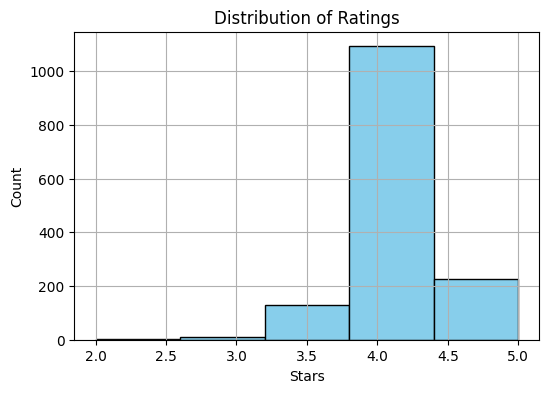

Average rating: 4.1

Top 5 Categories:
 category
Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables    231
Electronics|WearableTechnology|SmartWatches                                           76
Electronics|Mobiles&Accessories|Smartphones&BasicMobiles|Smartphones                  68
Electronics|HomeTheater,TV&Video|Televisions|SmartTelevisions                         63
Electronics|Headphones,Earbuds&Accessories|Headphones|In-Ear                          52
Name: count, dtype: int64


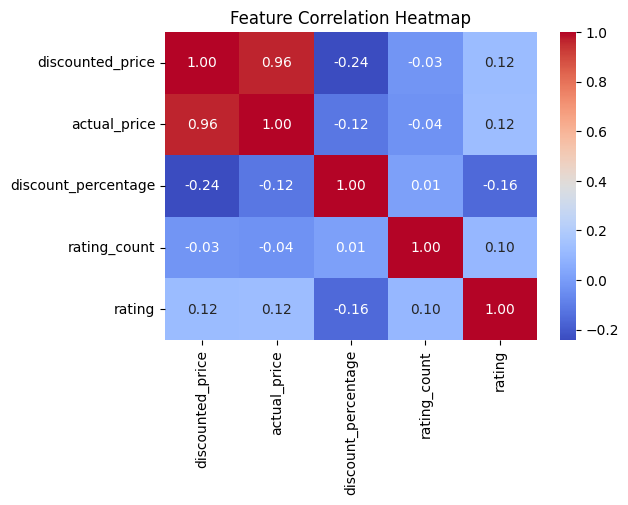

R² (numeric features): 0.0582
RMSE (numeric features): 0.278


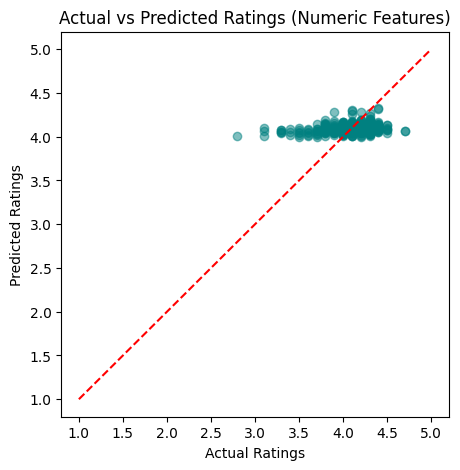


R² (text reviews): 0.0794
RMSE (text reviews): 0.274

=== Linear Regression Summary ===
R² (numeric only): 0.0582
R² (text reviews): 0.0794
RMSE (numeric): 0.278
RMSE (text): 0.274


In [157]:
# --- Imports ---
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

# ----------------------------------------------------
# 1. Get the dataset
# ----------------------------------------------------
folder_path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset")
print("Dataset downloaded to:", folder_path)

# find CSV file in that folder
file_name = [f for f in os.listdir(folder_path) if f.endswith(".csv")][0]
file_path = os.path.join(folder_path, file_name)

df = pd.read_csv(file_path)
print("Raw dataset shape:", df.shape)
df.head()

# ----------------------------------------------------
# 2. Clean up the data
# ----------------------------------------------------
# get rid of ₹ signs and commas, convert rupees -> USD
df['discounted_price'] = df['discounted_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011
df['actual_price'] = df['actual_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011

# remove '%' from discount and turn into float
df['discount_percentage'] = df['discount_percentage'].str.rstrip('%').astype(float)

# rating + rating_count to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = df['rating_count'].replace(',', '', regex=True).astype(float)

# drop rows missing these key values
df = df.dropna(subset=['discounted_price','actual_price','discount_percentage','rating_count','rating'])
print("Cleaned dataset shape:", df.shape)
df.info()

# ----------------------------------------------------
# 3. Quick EDA
# ----------------------------------------------------
plt.figure(figsize=(6,4))
df['rating'].hist(bins=5, color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()

print("Average rating:", round(df['rating'].mean(),2))
print("\nTop 5 Categories:\n", df['category'].value_counts().head())

# correlation heatmap for numeric features
plt.figure(figsize=(6,4))
sns.heatmap(df[['discounted_price','actual_price','discount_percentage','rating_count','rating']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# ----------------------------------------------------
# 4. Linear Regression (numeric features)
# ----------------------------------------------------
X = df[['discounted_price', 'actual_price', 'discount_percentage', 'rating_count']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_num = LinearRegression()
reg_num.fit(X_train, y_train)

r2_num = reg_num.score(X_test, y_test)
y_pred = reg_num.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² (numeric features):", round(r2_num,4))
print("RMSE (numeric features):", round(rmse,3))

# scatter plot actual vs predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Numeric Features)")
plt.plot([1,5],[1,5],'r--')
plt.show()

# ----------------------------------------------------
# 5. Linear Regression (review text using TF-IDF)
# ----------------------------------------------------
X_text = df['review_content'].fillna("")
y_text = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

reg_text = make_pipeline(TfidfVectorizer(max_features=5000), LinearRegression())
reg_text.fit(X_train, y_train)

r2_text = reg_text.score(X_test, y_test)
y_pred_text = reg_text.predict(X_test)
rmse_text = np.sqrt(mean_squared_error(y_test, y_pred_text))

print("\nR² (text reviews):", round(r2_text,4))
print("RMSE (text reviews):", round(rmse_text,3))

# ----------------------------------------------------
# 6. Wrap-up
# ----------------------------------------------------
print("\n=== Linear Regression Summary ===")
print(f"R² (numeric only): {r2_num:.4f}")
print(f"R² (text reviews): {r2_text:.4f}")
print(f"RMSE (numeric): {rmse:.3f}")
print(f"RMSE (text): {rmse_text:.3f}")

## Multi-Class Logistic Regression

In [158]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

In [159]:
import pandas as pd

# reloading the data cause nothing showed up for column
df = pd.read_csv(file_path)

print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())

# Clean the data again
df['discounted_price'] = df['discounted_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011
df['actual_price'] = df['actual_price'].replace('[₹,]', '', regex=True).astype(float) * 0.011
df['discount_percentage'] = df['discount_percentage'].str.rstrip('%').astype(float)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = df['rating_count'].replace(',', '', regex=True).astype(float)

# Drop rows missing key values
df = df.dropna(subset=['discounted_price','actual_price','discount_percentage','rating_count','rating'])

print("After cleaning shape:", df.shape)
print("\nChecking review columns:")
print(f"review_title non-null: {df['review_title'].notna().sum()}")
print(f"review_content non-null: {df['review_content'].notna().sum()}")

# NOW prepare review data
df_reviews = df[['review_title', 'review_content', 'rating']].copy()
print(f"\nBefore dropna: {len(df_reviews)} rows")

df_reviews = df_reviews.dropna()
print(f"After dropna: {len(df_reviews)} rows")

# Create combined text
df_reviews['text'] = (df_reviews['review_title'].astype(str) + " " + 
                      df_reviews['review_content'].astype(str))

# Convert to discrete classes
df_reviews['label'] = df_reviews['rating'].round().astype(int)

X_text = df_reviews['text']
y = df_reviews['label']

print(f"\nFinal number of reviews: {len(X_text)}")
print(f"Class distribution:\n{y.value_counts().sort_index()}")

Original shape: (1465, 16)
Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
After cleaning shape: (1462, 16)

Checking review columns:
review_title non-null: 1462
review_content non-null: 1462

Before dropna: 1462 rows
After dropna: 1462 rows

Final number of reviews: 1462
Class distribution:
label
2       2
3      39
4    1393
5      28
Name: count, dtype: int64


### TF-IDF (Term Frequency-Inverse Document Frequency)
First we use Term Frequency-Inverse Document Frequency to create a vector representation of our Amazon reviews. The term frequency is the number of times a word appears in the text. The Inverse Document Frequency accounts for very common words like 'the' or 'is'. Using TF-IDF reduces the weight of less informative words, giving a higher score to rare words. The result is a vector with one dimension per word in the vocabulary where the values are high for important or unique words and low for frequent/common words.

Running multi-class logistic regression with TF-IDF text-vectorization will allow us to highlight the most important words for each rating value.

In [160]:
# TF-IDF Vectorization - remove stop_words to avoid empty vocabulary error
vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
X_tfidf = vectorizer.fit_transform(X_text)

print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

TF-IDF shape: (1462, 5000)
Vocabulary size: 5000


#### Results
Running multi-class logistic regression on the text vectorized with TF-IDF and k-fold cross validation with k=5, we saw a mean accuracy score of 0.95. 

In [161]:
log_reg = LogisticRegression(max_iter = 2000, solver = 'lbfgs')
kf = KFold(n_splits=5, shuffle = True, random_state=42)
scores_tfidf = cross_val_score(log_reg, X_tfidf, y, cv=kf, scoring = 'accuracy')

print("K-Fold Accuracy Scores:", scores_tfidf)
print("Mean Accuracy:", scores_tfidf.mean())

log_reg.fit(X_tfidf, y)


K-Fold Accuracy Scores: [0.95221843 0.94197952 0.94863014 0.95205479 0.96917808]
Mean Accuracy: 0.9528121931834121


LogisticRegression(max_iter=2000)

#### Word Influence
To understand which words were influencing whether a review was given a score of 5 or not, we examined the weights of the top 20 words. Words with higher weights indicate a positive review, more likely to recieve 5 stars, and lower weights indicate a negative review. 

Examining the top words that predict 5 star reviews can help us determine successful marketing techniques or the most liked features. For example, we can see that 'instagram' has a high weight of 0.596 and will be more likely to lead to a positive review. From this we could advise a company to expand advertising to social media, as people mention Instagram in positive reviews. We can also identify the features most disliked, as words like 'weight' and 'price' are seen to lead to negative reviews, indicating customers were not satisifed with these qualities. 

In [162]:
feature_names = vectorizer.get_feature_names_out()
coefs = log_reg.coef_

class_idx = np.where(log_reg.classes_ == 5)[0][0]
coef_class = log_reg.coef_[class_idx]

top_pos_idx = np.argsort(coef_class)[-20:]
top_neg_idx = np.argsort(coef_class)[:20]

print("\nTop words that predict 5-star reviews:")
for i in reversed(top_pos_idx):
    print(f"{feature_names[i]} : {coef_class[i]:.3f}")

print("\nTop words that predict against 5-star reviews (lean towards lower ratings):")
for i in top_neg_idx:
    print(f"{feature_names[i]} : {coef_class[i]:.3f}")


Top words that predict 5-star reviews:
mouse : 1.313
easy : 0.748
best : 0.647
screen : 0.644
amazing : 0.567
must : 0.562
and : 0.553
instagram : 0.543
install : 0.504
pad : 0.491
big : 0.472
coffee : 0.447
clips : 0.433
wonders : 0.426
installation : 0.411
ओर : 0.396
demo : 0.386
products : 0.381
instant : 0.379
tempered : 0.368

Top words that predict against 5-star reviews (lean towards lower ratings):
not : -0.606
ok : -0.444
charging : -0.419
good : -0.385
remote : -0.378
watch : -0.377
price : -0.291
can : -0.288
battery : -0.283
amazon : -0.261
only : -0.259
nice : -0.253
power : -0.252
work : -0.239
bad : -0.227
does : -0.222
which : -0.221
usb : -0.203
received : -0.202
cable : -0.202


### Semantic Embedding
We will use semantic embeddings to create a dense vector where dimensions represent the meaning of the word rather than the frequency. This allows the model to learn relationship between sentences like 'I love this product' and 'this product is great' as it understands the positive relationship between 'love' and 'great'. We will SentenceTransformer to create a vector with 384 dimensions representing the meaning of the reviews. 

Running multi-class logistic regression on the amazon review content will allow us to utilize the context of the entire review to predict the rating.

In [163]:
### Semantic Embedding Section
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("Generating semantic embeddings...")
X_semantic = embedder.encode(X_text.tolist(), convert_to_numpy=True, show_progress_bar=True)
print(f"Semantic embeddings shape: {X_semantic.shape}")

Generating semantic embeddings...


Batches: 100%|██████████| 46/46 [00:21<00:00,  2.10it/s]

Semantic embeddings shape: (1462, 384)


### Results
Running multi-class logistic regression on the vector embedded with  and k-fold cross validation with k=5, we saw a mean accuracy score of 0.95. 

This is the same result as the TF-IDF model despite the different text representation strategies. We can attribute this to both the size of the data set and the length of the reviews. The data set we are working with is small (1465 ratings) which can depreciate the benefit of embeddings, as the model does not have enough data to learn from. To see a difference in the text representation strategies we should consider a larger data set, allowing the model enough text to exploit the semantic differences and contextual information. Additionally, because the reviews are generally short, to-the-point sentences, the semantic embeddings do not capture much deeper sentence meaning. Most reviews are in the form of 'Great product', which is too simple to gain any significant contextual value from. While semantic embeddings are intended to capture deeper sentence meaning, when used for short pieces of texts they correlate strongly with the presence of key-words, essentially providing the same information as TF-IDF. 

In [164]:
# Train TF-IDF model
log_reg_tfidf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_tfidf = cross_val_score(log_reg_tfidf, X_tfidf, y, cv=kf, scoring='accuracy')

print("=== TF-IDF Results ===")
print("K-Fold Accuracy Scores:", scores_tfidf)
print("Mean Accuracy:", scores_tfidf.mean())

# Fit final TF-IDF model
log_reg_tfidf.fit(X_tfidf, y)
print("TF-IDF model fitted!")


from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("Generating semantic embeddings...")
X_semantic = embedder.encode(X_text.tolist(), convert_to_numpy=True, show_progress_bar=True)
print(f"Semantic embeddings shape: {X_semantic.shape}")

# Train Semantic model
log_reg_semantic = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_semantic = cross_val_score(log_reg_semantic, X_semantic, y, cv=kf, scoring='accuracy')

print("=== Semantic Embeddings Results ===")
print("K-Fold Accuracy Scores:", scores_semantic)
print("Mean Accuracy:", scores_semantic.mean())

# Fit final semantic model
log_reg_semantic.fit(X_semantic, y)
print("Semantic model fitted!")

### Compare Results
print("\n=== MODEL COMPARISON ===")
print(f"TF-IDF Mean Accuracy: {scores_tfidf.mean():.4f}")
print(f"Semantic Mean Accuracy: {scores_semantic.mean():.4f}")
print(f"Difference: {abs(scores_tfidf.mean() - scores_semantic.mean()):.4f}")

# Check if both are just predicting class 4
y_pred_tfidf = log_reg_tfidf.predict(X_tfidf)
y_pred_semantic = log_reg_semantic.predict(X_semantic)

print("\n=== Prediction Distributions ===")
print("TF-IDF predictions:")
print(pd.Series(y_pred_tfidf).value_counts().sort_index())
print("\nSemantic predictions:")
print(pd.Series(y_pred_semantic).value_counts().sort_index())
print("\nActual labels:")
print(y.value_counts().sort_index())

c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Benso\AppData\Local\Programs\Python\P

=== TF-IDF Results ===
K-Fold Accuracy Scores: [0.95221843 0.94197952 0.94863014 0.95205479 0.96917808]
Mean Accuracy: 0.9528121931834121
TF-IDF model fitted!
Generating semantic embeddings...


Batches: 100%|██████████| 46/46 [00:25<00:00,  1.81it/s]
c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warn

Semantic embeddings shape: (1462, 384)
=== Semantic Embeddings Results ===
K-Fold Accuracy Scores: [0.95221843 0.94197952 0.94863014 0.95205479 0.96917808]
Mean Accuracy: 0.9528121931834121
Semantic model fitted!

=== MODEL COMPARISON ===
TF-IDF Mean Accuracy: 0.9528
Semantic Mean Accuracy: 0.9528
Difference: 0.0000

=== Prediction Distributions ===
TF-IDF predictions:
4    1462
Name: count, dtype: int64

Semantic predictions:
4    1462
Name: count, dtype: int64

Actual labels:
label
2       2
3      39
4    1393
5      28
Name: count, dtype: int64


c:\Users\Benso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Semantic Influence
Although our accuracy did not change after applying semantic embeddings, we can utilize LIME to understand how each word influences the overall predictation. LIME (Local Interpretable Model-agnostic Explanations) is used to explain why a model made a certain prediction. It goes through the given text one word at a time and determines how each word influence the prediction (whether it pushes the rating towards 5 stars or towards 1 star)

Looking at the highlighted review we can visualize the idea of TF-IDF, as the most frequent terms are influencing the final prediction. Words that appear multiple times like 'good' and 'money' are highlighted to show their influencing. This is expected as TF-IDF focuses on the most frequent informative words. 

In [165]:
### LIME for TF-IDF
from lime.lime_text import LimeTextExplainer

def predict_proba_tfidf(texts):
    X_vec = vectorizer.transform(texts)
    return log_reg_tfidf.predict_proba(X_vec)  # Use TF-IDF model

# Create explainer
explainer_tfidf = LimeTextExplainer(class_names=[str(c) for c in log_reg_tfidf.classes_])

# Pick a sample (try different indices to find interesting ones)
sample_index = 0
sample_text = X_text.iloc[sample_index]
actual_label = y.iloc[sample_index]

print(f"=== LIME Explanation for TF-IDF ===")
print(f"Sample review (actual rating: {actual_label}):")
print(sample_text)

# Generate explanation
exp_tfidf = explainer_tfidf.explain_instance(
    sample_text, 
    predict_proba_tfidf, 
    num_features=10,
    top_labels=1
)

# Show visualization
exp_tfidf.show_in_notebook(text=True)

=== LIME Explanation for TF-IDF ===
Sample review (actual rating: 4):
Satisfied,Charging is really fast,Value for money,Product review,Good quality,Good product,Good Product,As of now seems good Looks durable Charging is fine tooNo complains,Charging is really fast, good product.,Till now satisfied with the quality.,This is a good product . The charging speed is slower than the original iPhone cable,Good quality, would recommend,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/81---F1ZgHL._SY88.jpg,Product had worked well till date and was having no issue.Cable is also sturdy enough...Have asked for replacement and company is doing the same...,Value for money


Using LIME to visualize the influence of words using semantic embeddings, we can see why both text representation techniques resulted in the same mean accuracy score. While the semantic embeddings does pick out words because of the context like 'value' and 'replacement' (which do not influence the score using vectorization since they are not frequently used), it is mainly influenced by the frewuenct keywords. The word 'good' is repeated multiple times in the review and has a strong influence on the prediction. Because the reviews are short and do not have much context to exploit, the semantic embedding ultimately show the same words that influence the prediction. 

In [166]:
### LIME for Semantic Embeddings
def predict_proba_semantic(texts):
    embeddings = embedder.encode(texts, convert_to_numpy=True)
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(1, -1)
    return log_reg_semantic.predict_proba(embeddings)  # ✅ Use semantic model

# Create explainer
explainer_semantic = LimeTextExplainer(class_names=[str(c) for c in log_reg_semantic.classes_])

print(f"\n=== LIME Explanation for Semantic Embeddings ===")
print(f"Sample review (actual rating: {actual_label}):")
print(sample_text)

# Generate explanation
exp_semantic = explainer_semantic.explain_instance(
    sample_text,
    predict_proba_semantic,
    num_features=10,
    top_labels=1,
    num_samples=5000
)

# Show visualization
exp_semantic.show_in_notebook(text=True)


=== LIME Explanation for Semantic Embeddings ===
Sample review (actual rating: 4):
Satisfied,Charging is really fast,Value for money,Product review,Good quality,Good product,Good Product,As of now seems good Looks durable Charging is fine tooNo complains,Charging is really fast, good product.,Till now satisfied with the quality.,This is a good product . The charging speed is slower than the original iPhone cable,Good quality, would recommend,https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/81---F1ZgHL._SY88.jpg,Product had worked well till date and was having no issue.Cable is also sturdy enough...Have asked for replacement and company is doing the same...,Value for money
